## One Model

rosshandler: https://pubmed.ncbi.nlm.nih.gov/37982461/ \
nowotschin: https://pubmed.ncbi.nlm.nih.gov/30959515/ \
https://www.nature.com/articles/s41592-021-01336-8 \
https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scrna/harmonization.html \
https://rapids-singlecell.readthedocs.io/en/latest/notebooks/demo_gpu-seuratv3-brain-1M.html 

In [1]:
%%time
# importing our library 
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import torch
import os
import scipy
from scipy.io import mmread
from scipy.io import mmwrite
import anndata as ad
import psutil
import h5py
import rapids_singlecell as rsc
import jax
import matplotlib
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import seaborn as sns
from plotly.validators.scatter.marker import SymbolValidator
from plotly import graph_objects as go

Global seed set to 0
/home/schroel1/miniconda3/envs/gpu2/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/schroel1/miniconda3/envs/gpu2/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


CPU times: user 5.41 s, sys: 1.59 s, total: 6.99 s
Wall time: 1min 22s


## Memory

In [2]:
## RAM info

# Get information about virtual memory usage
virtual_mem = psutil.virtual_memory()
# Access attributes like total, available, and used memory
total_mem = virtual_mem.total  # Total memory in bytes
available_mem = virtual_mem.available  # Available memory in bytes
used_mem = virtual_mem.used  # Used memory in bytes
# You can also calculate memory usage percentage
percent_used = used_mem / total_mem * 100

# printing it out
print(f"Total Memory: {total_mem / (1024**3)} GB")
print(f"Available Memory: {available_mem / (1024**3)} GB")
print(f"Used Memory: {used_mem / (1024**3)} GB")
print(f"Memory Usage Percentage: {percent_used:.2f}%")

Total Memory: 1007.155345916748 GB
Available Memory: 911.1340675354004 GB
Used Memory: 93.17755126953125 GB
Memory Usage Percentage: 9.25%


## Cuda, torch and jax setup

In [3]:
!nvidia-smi

Wed Nov  6 15:23:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40                     On  | 00000000:E3:00.0 Off |                    0 |
|  0%   35C    P0              78W / 300W |    273MiB / 46068MiB |      0%   E. Process |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
print(torch.version.cuda)
use_cuda = torch.cuda.is_available()
use_cuda

11.8


True

In [5]:
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

__CUDNN VERSION: 90100
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA A40
__CUDA Device Total Memory [GB]: 47.622258688


In [6]:
## trading of performance for accuracy, can be set to `medium` `high` `highest`
torch.set_float32_matmul_precision('high')

In [7]:
print(torch.backends.cudnn.version())

90100


In [8]:
jax.default_backend() 

'gpu'

## SETTING PATH

In [9]:
data_path = '/data/hadjantalab/lucas/atlas/data'

## LOADING COMPLETE DATASET AND SUBSETTING

In [10]:
file_path = os.path.join(data_path, 'adata.h5ad')
adata = ad.read_h5ad(file_path)
adata

AnnData object with n_obs × n_vars = 535935 × 8342
    obs: 'batch', 'stage', 'sample', 'covariate_composite', 'celltype_nowotschin', 'celltype_rosshandler', 'celltype_pijuansala', 'nowotschin_cluster', 'rosshandler_somite_count', 'rosshandler_anatomy', 'rosshandler_phase', 'rosshandler_S_score', 'rosshandler_G2M_score', 'rosshandler_louvain', 'rosshandler_leiden', 'annotation', 'mt-Atp6', 'mt-Atp8', 'mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd3', 'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'colormap_annotation', 'colormap_batch', 'colormap_rosshandler', 'colormap_stage', 'log1p', 'neighbors_scVI', 'phase_colors', 'symbolmap_batch', 'symbolmap_plotly_batch', 'symbolmap_plotly_stage', 'symbolmap_stage', 'umap'
    obsm: 'X_scVI', 'X_umap', 'X_umap_scVI', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'log_no

In [11]:
with pd.option_context('display.max_rows', None):
  print(adata.obs['celltype_nowotschin'].value_counts())

unknown                  422884
Mes                       20248
exVE                      19584
ParE                      11289
EPI                        8969
YsE                        8837
emVE                       6339
Gut tube:VE:Pancreas       5291
ExE                        4936
DE                         3554
Gut tube:DE:Thymus         3443
Gut tube:VE:Small int      2700
Gut tube:DE:Lung           2443
Gut tube:VE:Colon          2414
Blood                      1898
Gut tube                   1823
Midline                    1425
Gut tube:DE:Thyroid        1255
Gut tube:VE:Liver          1207
Endothelial                 987
Gut tube:VE:Lung            930
Gut tube:DE:Small int       901
TE                          741
Gut tube:DE:Pancreas        511
PrE                         409
ICM                         268
GermCells                   226
Gut tube:DE:Liver           190
Gut tube:VE:Thymus          154
VE                           40
Gut tube:DE:Colon            28
Gut tube

In [13]:
with pd.option_context('display.max_rows', None):
  print(adata.obs['celltype_rosshandler'].value_counts())

unknown                                           113051
Erythroid                                          38975
ExE endoderm                                       15635
Ventral hindbrain progenitors                      13158
Optic vesicle                                      12409
Mesenchyme                                         12096
Epiblast                                           12088
Lateral plate mesoderm                             11107
Sclerotome                                         10688
ExE ectoderm                                       10389
Dorsal spinal cord progenitors                     10381
Limb mesoderm                                      10014
Allantois                                           8515
Migratory neural crest                              8413
Spinal cord progenitors                             8343
Pharyngeal endoderm                                 7931
Presomitic mesoderm                                 7825
Midbrain_Hindbrain boundary    

In [14]:
populations_of_interest_ross = [
    'Anterior cardiopharyngeal progenitors', 
    'Anterior somitic tissues', 
    'Cardiomyocytes FHF 1',
    'Cardiomyocytes FHF 2',
    'Cardiomyocytes SHF 1',
    'Cardiomyocytes SHF 2',
    'Cardiopharyngeal progenitors',
    'Cardiopharyngeal progenitors FHF',
    'Cardiopharyngeal progenitors SHF',
    'Caudal mesoderm', 
    'Cranial mesoderm',
    'Dermomyotome',
    'Embryo proper endothelium',
    'Embryo proper mesothelium',
    'Endocardium',
    'Endotome',
    'Epicardium',
    'Erythroid',
    'Frontonasal mesenchyme',
    'Haematoendothelial progenitors',
    'Intermediate mesoderm',
    'Kidney primordium',
    'Lateral plate mesoderm',
    'Limb mesoderm',
    'MEP',
    'Megakaryocyte progenitors',
    'Mesenchyme',
    'NMPs',
    'NMPs/Mesoderm-biased',
    'Nascent mesoderm',
    'Paraxial mesoderm',
    'Pharyngeal mesoderm',
    'Presomitic mesoderm',
    'Sclerotome',
    'Somitic mesoderm',
    'YS mesothelium',
    'YS mesothelium-derived endothelial progenitors'
    ]
populations_of_interest_nowo = [
    'Mes'
]

In [15]:
## extracting only the above defined celltypes
mask_populations = (adata.obs['celltype_rosshandler'].isin(populations_of_interest_ross)) | (adata.obs['celltype_nowotschin'].isin(populations_of_interest_nowo))
adata = adata[mask_populations,:].copy()

In [16]:
## stages to keep
stages = ['E8.0', 'E8.25', 'E8.5', 'E8.75', 'E9.0', 'E9.25', 'E9.5']
mask_stages = adata.obs['stage'].isin(stages)
adata = adata[mask_stages,:].copy()

In [17]:
##NEW
with pd.option_context('display.max_rows', None):
    print(adata.obs['sample'].value_counts().sort_values(ascending=True).head(n=10))

Lib11-1_E8.5_GFP+     34
Lib11-2_E8.5_GFP+     39
58.0                 552
42.0                 580
54.0                 591
86.0                 741
102.0                770
E85posterior2B       784
E85posterior2A       832
41.0                 869
Name: sample, dtype: int64


In [18]:
##NEW
with pd.option_context('display.max_rows', None):
    print(adata.obs['celltype_rosshandler'].value_counts().sort_values(ascending=True))

YS mesothelium-derived endothelial progenitors      108
Haematoendothelial progenitors                      156
Megakaryocyte progenitors                           806
Paraxial mesoderm                                   895
MEP                                                1176
Cardiopharyngeal progenitors                       1530
Anterior cardiopharyngeal progenitors              1674
Intermediate mesoderm                              1856
Cardiomyocytes SHF 1                               1947
Cardiomyocytes SHF 2                               1989
Frontonasal mesenchyme                             2126
Endocardium                                        2192
Cardiomyocytes FHF 1                               2408
Cardiomyocytes FHF 2                               2504
Cranial mesoderm                                   2704
Cardiopharyngeal progenitors FHF                   2882
Epicardium                                         3034
Caudal mesoderm                                 

In [22]:
##NEW
## FILTERING celltypes WITH LESS THAN 30 CELLS
#valid_samples = adata.obs['celltype_rosshandler'].value_counts()[lambda x: x >= 30].index
a#data = adata[adata.obs['celltype_rosshandler'].isin(valid_samples)].copy()

In [19]:
adata.obs['stage'].value_counts().sort_index()

E8.0      7146
E8.5     29174
E9.25    33365
E9.5     17547
E8.25     7833
E9.0     42454
E8.75    44944
Name: stage, dtype: int64

In [20]:
adata.obs['batch'].value_counts().sort_index()

pijuan-sala     23795
rosshandler    146638
nowotschin      12030
Name: batch, dtype: int64

## scVI Model

In [21]:
obs_continuous_covariates = [
    'mt-Atp6',
    'mt-Atp8',
    'mt-Co1',
    'mt-Co2',
    'mt-Co3',
    'mt-Cytb',
    'mt-Nd1',
    'mt-Nd2',
    'mt-Nd3',
    'mt-Nd4',
    'mt-Nd4l',
    'mt-Nd5',
    'mt-Nd6',
    'S_score',
    'G2M_score',
]

In [22]:
## hyperparameters inferred from hyperparameter tuning
n_hidden = 256
n_layers = 1
n_latent = 45
lr = 0.0032
## n_epochs from https://github.com/theislab/scib-reproducibility/blob/main/notebooks/integration/scanvi.ipynb
n_epochs = np.min([round((20000/adata.n_obs)*400), 400]) ## can not be passed, but this will be used as n_epochs
print(f'Anticipated number of epochs: {n_epochs}') 
batch_size = 148 ## batch_size=128 made my model crash for some reason

Anticipated number of epochs: 44


In [23]:
%%time
scvi.model.SCVI.setup_anndata(adata, 
                              batch_key="batch", 
                              categorical_covariate_keys = ['sample', 'stage'],
                              continuous_covariate_keys = obs_continuous_covariates)

/home/schroel1/miniconda3/envs/gpu2/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


CPU times: user 111 ms, sys: 25.2 ms, total: 136 ms
Wall time: 1.07 s


In [24]:
%%time
model = scvi.model.SCVI(adata, gene_likelihood="nb", n_layers = n_layers, n_hidden = n_hidden, n_latent = n_latent)

CPU times: user 384 ms, sys: 237 ms, total: 621 ms
Wall time: 1.54 s


In [29]:
# some additional information if necessary

#model.view_anndata_setup()
#print(f"adata UUID (assigned by setup_anndata): {adata.uns['_scvi_uuid']}")
#print(f"AnnDataManager: {model._setup_adata_manager_store[adata.uns['_scvi_uuid']]}")
#print(model.get_anndata_manager(adata))
#model.__class__
## https://docs.scvi-tools.org/en/stable/tutorials/notebooks/dev/model_user_guide.html 
## https://anndata.readthedocs.io/en/latest/tutorials/notebooks/annloader.html 

In [25]:
%%time
model.train(plan_kwargs={"lr": lr}, 
            batch_size = batch_size, 
            validation_size = 0.1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/44:   0%|          | 0/44 [00:00<?, ?it/s]

/home/schroel1/miniconda3/envs/gpu2/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 44/44: 100%|██████████| 44/44 [07:07<00:00,  9.56s/it, loss=2.73e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=44` reached.


Epoch 44/44: 100%|██████████| 44/44 [07:07<00:00,  9.72s/it, loss=2.73e+03, v_num=1]
CPU times: user 7min 16s, sys: 53.5 s, total: 8min 9s
Wall time: 7min 8s


## LATENT SPACE

In [26]:
%%time
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

CPU times: user 4.53 s, sys: 1.17 s, total: 5.7 s
Wall time: 4.36 s


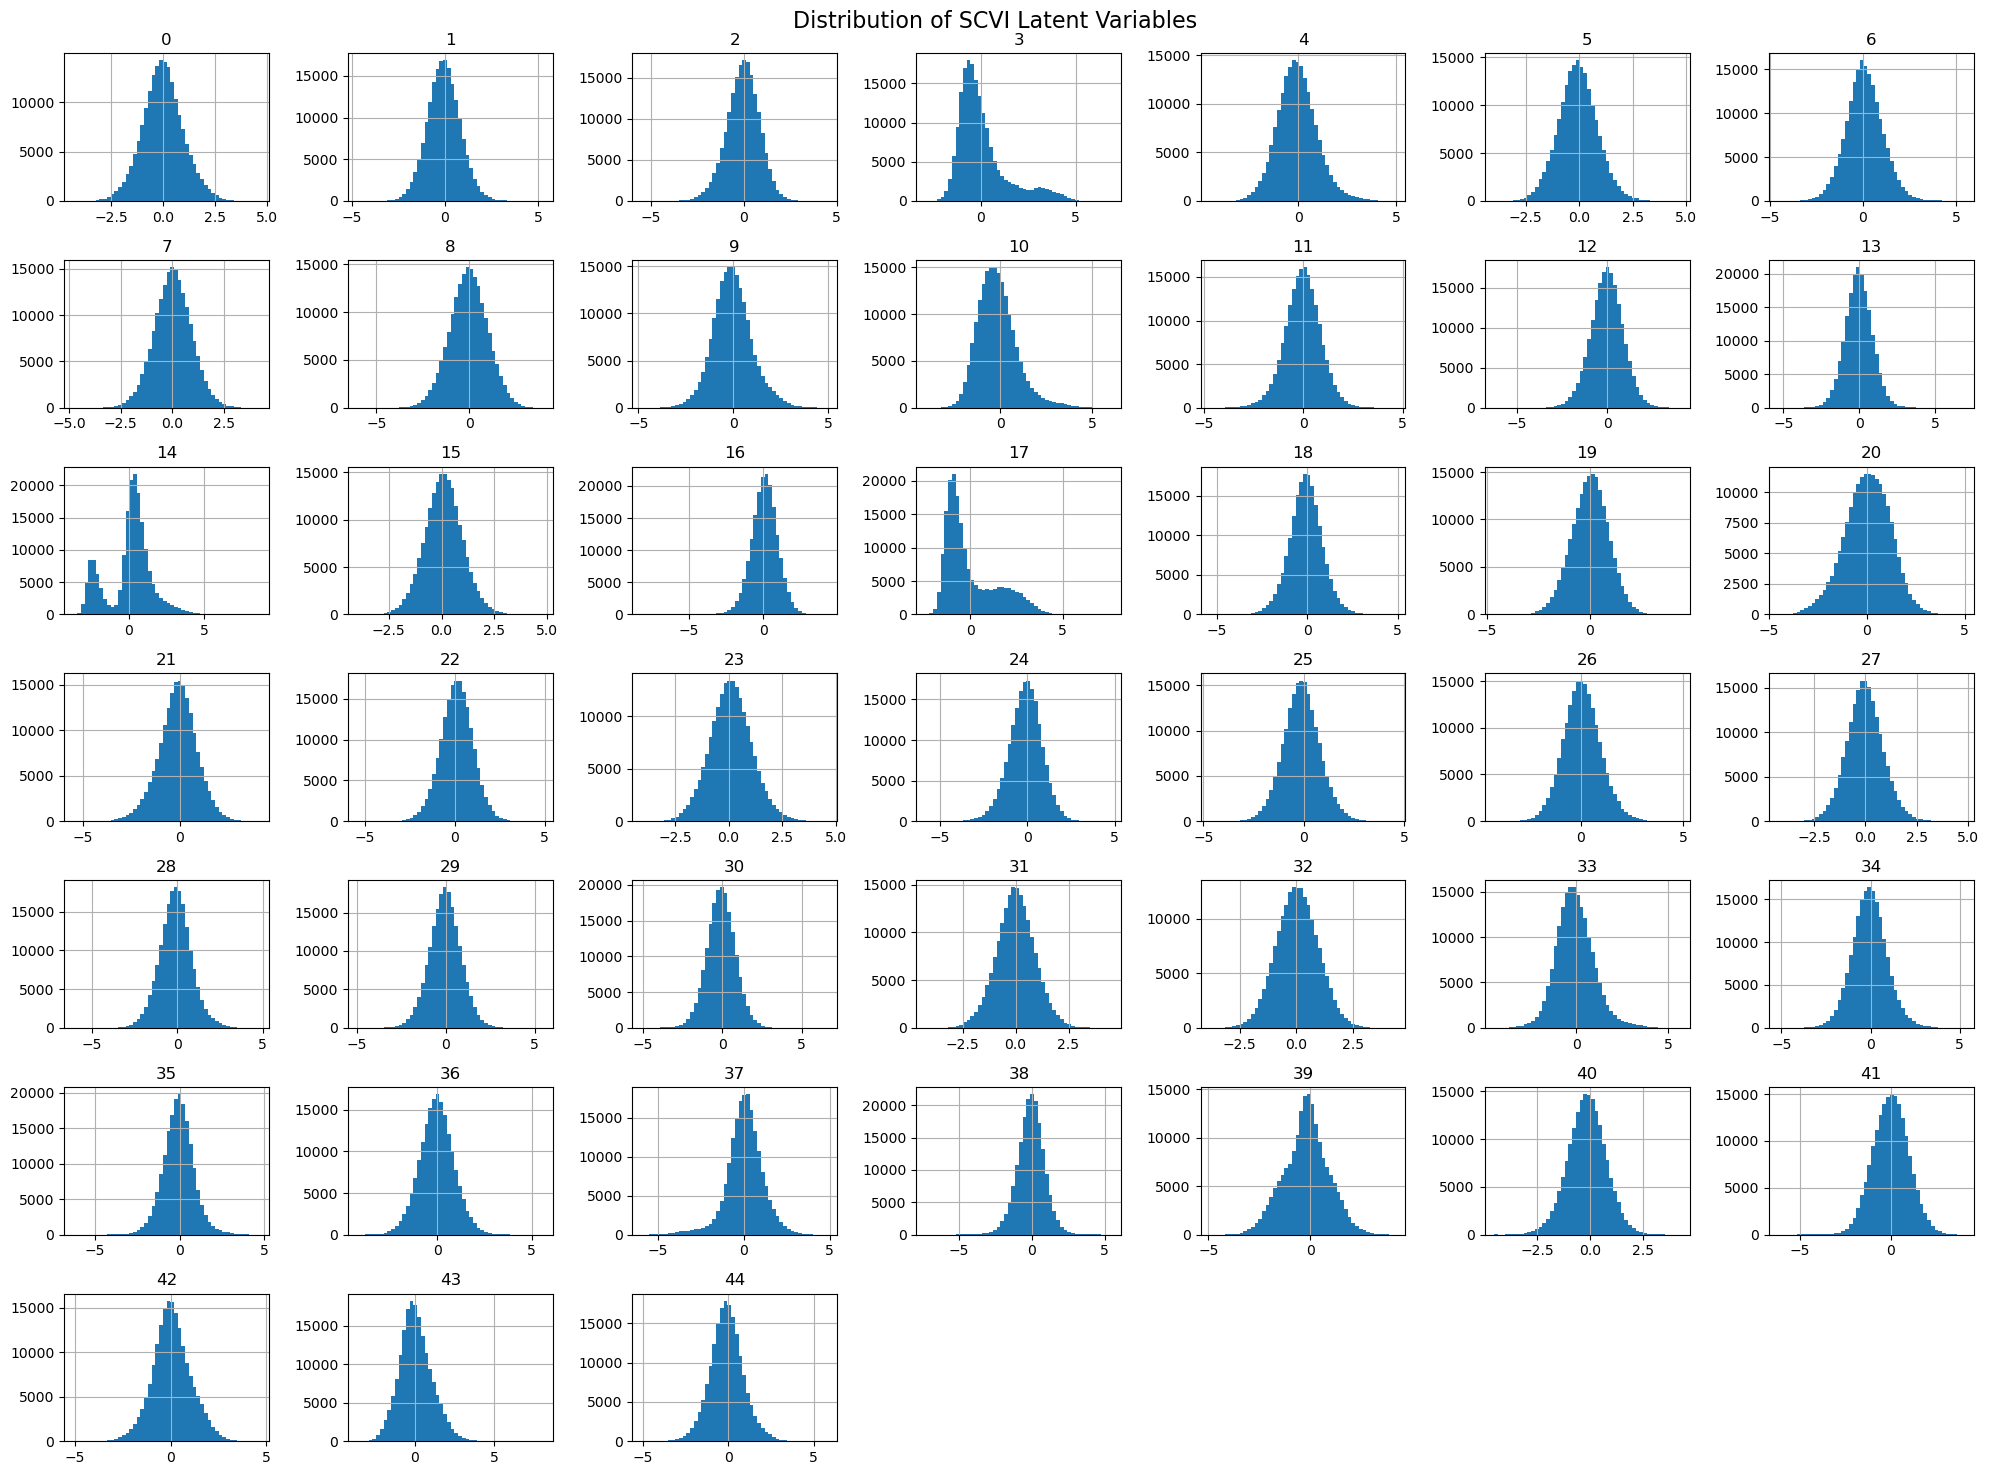

In [27]:
##NEW
# Extract the SCVI latent variables from the obsm slot
scVI_latent = pd.DataFrame(adata.obsm["X_scVI"])

# Plot histograms for each latent variable
scVI_latent.hist(bins=50, figsize=(20, 15))
plt.suptitle('Distribution of SCVI Latent Variables', fontsize=16)
plt.tight_layout()
plt.show()

## NEIGHBORS / UMAP

In [28]:
%%time
rsc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY, n_neighbors = 60, key_added = 'neighbors_scVI')

CPU times: user 1.45 s, sys: 813 ms, total: 2.26 s
Wall time: 4.41 s


In [29]:
%%time
rsc.tl.umap(adata, neighbors_key = 'neighbors_scVI', min_dist=0.5, spread = 0.5, n_components = 2, random_state = 66)
adata.obsm['X_umap_scVI'] = adata.obsm['X_umap'].copy()

CPU times: user 1.04 s, sys: 729 ms, total: 1.77 s
Wall time: 2.25 s


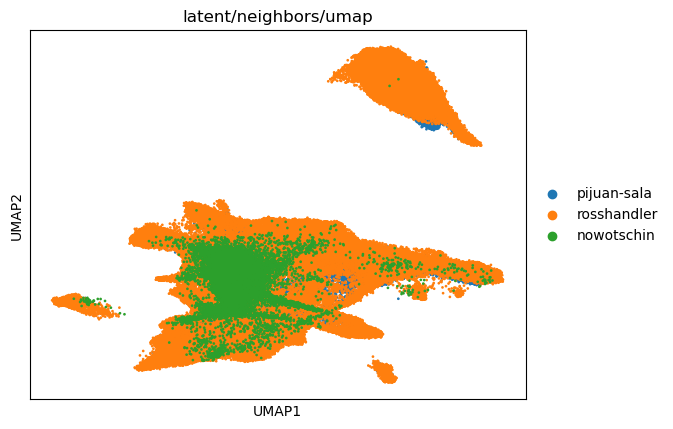

In [30]:
sc.pl.umap(adata, color = 'batch', title = 'latent/neighbors/umap', size = 15)

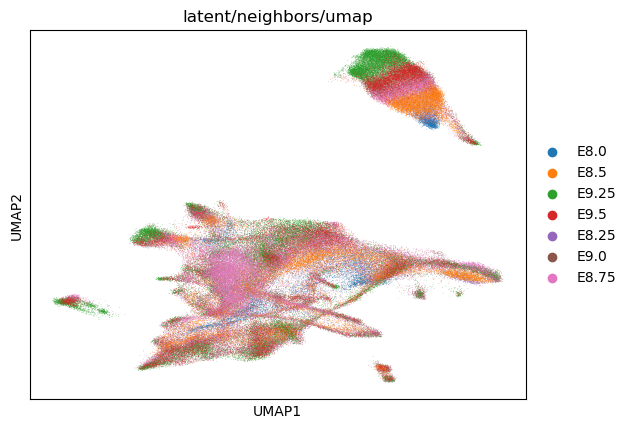

In [31]:
sc.pl.umap(adata, color = 'stage', title = 'latent/neighbors/umap')

## louvain CLUSTERING

In [47]:
%%time
## creating different resolutions for the louvain to pick one with 10-15 clusters

# Define the range of resolutions (1.0 to 0.01 with 0.5 steps)
resolutions = [round(r * 0.01, 2) for r in range(130, -10, -5)]  # [1.0, 0.5, 0.01]

# List to store clustering results
cluster_label_list = []

# Perform louvain clustering for all resolutions and store the cluster labels
for res in resolutions:
    sc.tl.louvain(adata, resolution=res, neighbors_key='neighbors_scVI', key_added=f'louvain_res_{res}', flavor = 'rapids')
    # Store the clustering labels for the current resolution
    cluster_label_list.append(adata.obs[f'louvain_res_{res}'].values)


/home/schroel1/miniconda3/envs/gpu2/lib/python3.10/site-packages/scanpy/tools/_louvain.py:198: FutureWarning: `flavor='rapids'` is deprecated. Use `rapids_singlecell.tl.louvain` instead.
  warnings.warn(msg, FutureWarning)
/home/schroel1/miniconda3/envs/gpu2/lib/python3.10/site-packages/scanpy/tools/_louvain.py:198: FutureWarning: `flavor='rapids'` is deprecated. Use `rapids_singlecell.tl.louvain` instead.
  warnings.warn(msg, FutureWarning)
/home/schroel1/miniconda3/envs/gpu2/lib/python3.10/site-packages/scanpy/tools/_louvain.py:198: FutureWarning: `flavor='rapids'` is deprecated. Use `rapids_singlecell.tl.louvain` instead.
  warnings.warn(msg, FutureWarning)
/home/schroel1/miniconda3/envs/gpu2/lib/python3.10/site-packages/scanpy/tools/_louvain.py:198: FutureWarning: `flavor='rapids'` is deprecated. Use `rapids_singlecell.tl.louvain` instead.
  warnings.warn(msg, FutureWarning)
/home/schroel1/miniconda3/envs/gpu2/lib/python3.10/site-packages/scanpy/tools/_louvain.py:198: FutureWarning

CPU times: user 31.3 s, sys: 40.2 s, total: 1min 11s
Wall time: 4min 31s


In [48]:
## Checking how many clusters per resolution

# Loop through both the resolution and cluster labels at the same time
for res, cluster in zip(resolutions, cluster_label_list):
    # Get unique values and their counts
    unique, counts = np.unique(cluster, return_counts=True)
    # Print the resolution and corresponding cluster counts
    print(f"Resolution: {res}\t\tNumber of clusters {len(unique)}")
    #print(dict(zip(unique, counts)))


Resolution: 1.3		Number of clusters 28
Resolution: 1.25		Number of clusters 27
Resolution: 1.2		Number of clusters 26
Resolution: 1.15		Number of clusters 23
Resolution: 1.1		Number of clusters 25
Resolution: 1.05		Number of clusters 21
Resolution: 1.0		Number of clusters 25
Resolution: 0.95		Number of clusters 23
Resolution: 0.9		Number of clusters 23
Resolution: 0.85		Number of clusters 23
Resolution: 0.8		Number of clusters 19
Resolution: 0.75		Number of clusters 19
Resolution: 0.7		Number of clusters 17
Resolution: 0.65		Number of clusters 17
Resolution: 0.6		Number of clusters 16
Resolution: 0.55		Number of clusters 16
Resolution: 0.5		Number of clusters 13
Resolution: 0.45		Number of clusters 12
Resolution: 0.4		Number of clusters 12
Resolution: 0.35		Number of clusters 10
Resolution: 0.3		Number of clusters 10
Resolution: 0.25		Number of clusters 8
Resolution: 0.2		Number of clusters 8
Resolution: 0.15		Number of clusters 7
Resolution: 0.1		Number of clusters 5
Resolution: 0.05	

In [52]:
len(np.unique(adata.obs['celltype_rosshandler']))

36

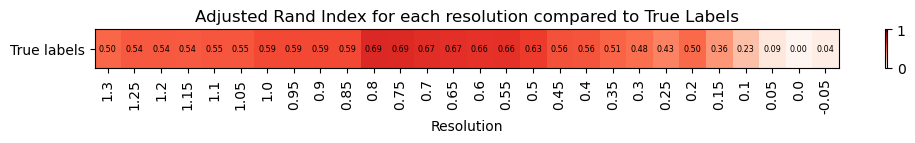

In [49]:
from sklearn.metrics import adjusted_rand_score

# Assuming 'adata' is your AnnData object and 'neighbors_scVI' has been computed
true_labels = adata.obs['celltype_rosshandler'].values

# Now compute the ARI array for all resolutions
ari_scores = np.zeros(len(resolutions))

# Compute ARI for each resolution against the true labels
for j in range(len(resolutions)):
    ari_scores[j] = adjusted_rand_score(true_labels, cluster_label_list[j])

# Plotting the ARI heatmap
fig, ax = plt.subplots(1, 1, figsize=(12, 0.5))
im = ax.imshow(ari_scores.reshape(1, -1), cmap='Reds', vmin=0, vmax=1, aspect='auto')  # Reshape to 1xN for heatmap
fig.colorbar(im, ax=ax)

# Set ticks and labels for the axes
ax.set_xticks(range(len(resolutions)))
ax.set_xticklabels(resolutions, rotation=90)
ax.set_yticks([0])
ax.set_yticklabels(['True labels'])
ax.set_xlabel('Resolution')
ax.set_title('Adjusted Rand Index for each resolution compared to True Labels')

# Add text annotations inside the heatmap rectangles
for j in range(len(resolutions)):  # Iterate over columns (resolutions)
    ax.text(j, 0, f"{ari_scores[j]:.2f}", ha='center', va='center', color='black', fontsize='xx-small')

plt.show()


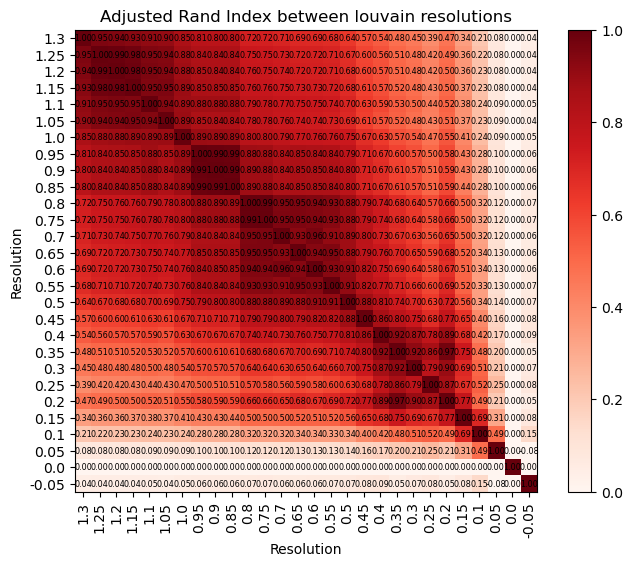

In [50]:
from sklearn.metrics import adjusted_rand_score

# Assume 'adata' is your AnnData object and 'neighbors_scVI' has been computed

# Now compute the ARI matrix for all pairs of resolutions
rand_index_mat = np.zeros((len(resolutions), len(resolutions)))

# Compute ARI for each pair of resolutions
for i in range(len(resolutions)):
    for j in range(len(resolutions)):
        rand_index_mat[i, j] = adjusted_rand_score(cluster_label_list[i], cluster_label_list[j])

# Plotting the ARI heatmap
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
im = ax.imshow(rand_index_mat, cmap='Reds', vmin=0, vmax=1)
fig.colorbar(im, ax=ax)

# Set ticks and labels for the axes
ax.set_xticks(range(len(resolutions)))
ax.set_xticklabels(resolutions, rotation=90)
ax.set_yticks(range(len(resolutions)))
ax.set_yticklabels(resolutions)
ax.set_xlabel('Resolution')
ax.set_ylabel('Resolution')
ax.set_title('Adjusted Rand Index between louvain resolutions')

# Add text annotations inside the heatmap rectangles
for i in range(len(resolutions)):
    for j in range(len(resolutions)):
        ax.text(j, i, f"{rand_index_mat[i, j]:.2f}", ha='center', va='center', color='black', fontsize = 'xx-small')

plt.show()


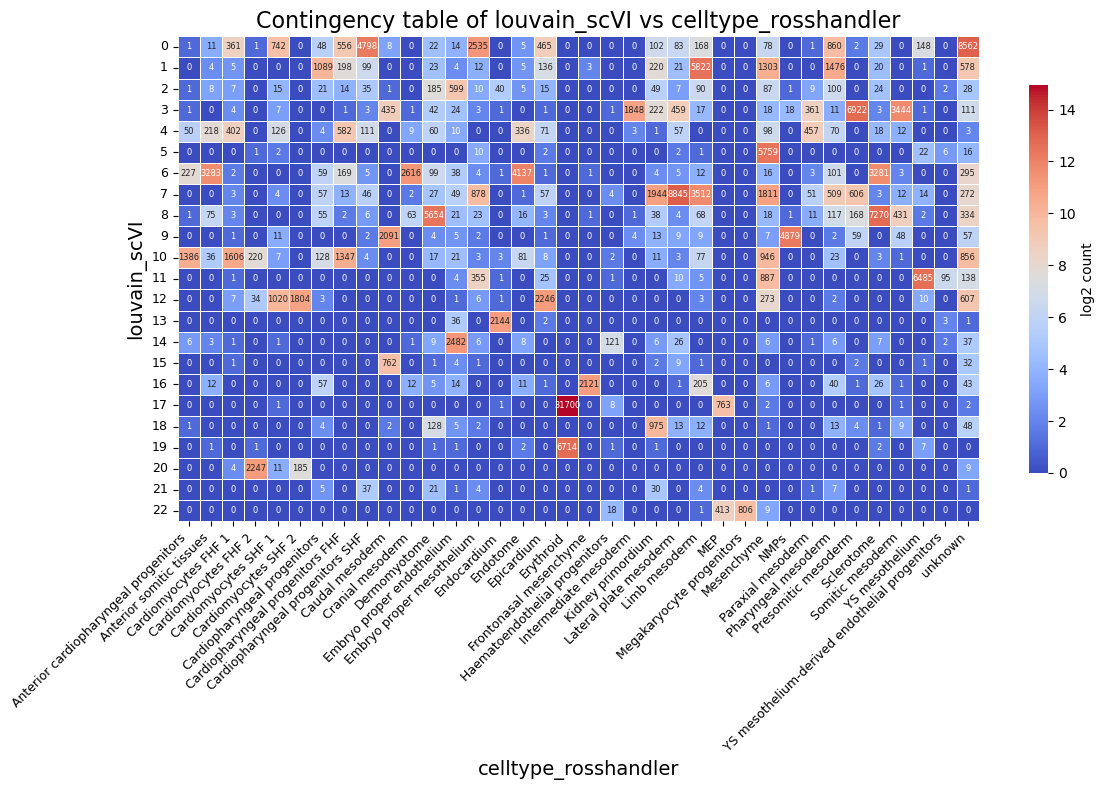

In [57]:

# Step 1: Create the contingency table
contingency_table = pd.crosstab(adata.obs['louvain_res_0.95'], adata.obs['celltype_rosshandler'])

# Step 2: Apply log2 transformation to the counts for the color scale
log2_contingency_table = np.log2(contingency_table + 1)  # Add 1 to avoid log(0) issues

# Step 3: Set the figure size and plot the heatmap
plt.figure(figsize=(12,8))  # Adjust figure size for better readability
heatmap = sns.heatmap(log2_contingency_table, 
                      annot=contingency_table,  # Use raw counts for annotations
                      fmt="d",                  # Format annotations as integers
                      cmap="coolwarm",          # Color map for better contrast
                      linewidths=.5,            # Add gridlines for clarity
                      cbar_kws={'shrink': .8, 'label': 'log2 count'},  # Adjust the color bar size
                      annot_kws={"size": 6})   # Set font size for annotations

# Step 4: Adjust axis labels and title
plt.title('Contingency table of louvain_scVI vs celltype_rosshandler', fontsize=16)
plt.xlabel('celltype_rosshandler', fontsize=14)
plt.ylabel('louvain_scVI', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right", fontsize=9)  # Rotate for better fit
plt.yticks(rotation=0, fontsize=9)               # Keep y-axis labels horizontal

# Step 5: Adjust layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()


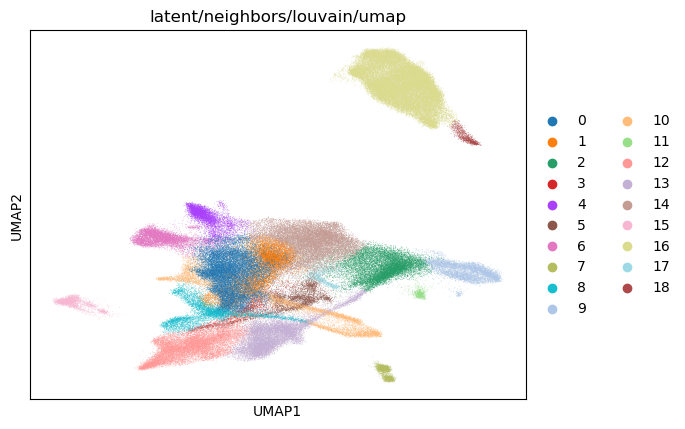

In [69]:
sc.pl.umap(adata, color = 'louvain_res_0.8', title = 'latent/neighbors/louvain/umap')

In [44]:
## SETTING louvain RESOLUTION THAT IS GOING TO BE USED

In [70]:
## SETTING THE louvain RESOLUTION THAT WE GONNA USE FOR DGE
adata.obs['louvain_scVI'] = adata.obs['louvain_res_0.8'].copy()

## SIMPLE LABEL TRANSFER VIA NEAREST NEIGHBORS

In [59]:
%%time
## getting the nearest neighbors
SCVI_LATENT_KEY = "X_scVI"
n_neighbors = 100
rsc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY, n_neighbors = n_neighbors, key_added = f'neighbors_{n_neighbors}_scVI')

CPU times: user 2.72 s, sys: 1.71 s, total: 4.43 s
Wall time: 4.9 s


In [60]:
from scipy.stats import mode

# Define the subset of interest
mask_subset = (adata.obs['batch'] == 'nowotschin')

# Define the subset of interest as integer indices
subset_indices = np.where(mask_subset)[0]  # Get integer positions of the subset

# Initialize a list to store the most common annotation for each cell in the subset
nn_transfer = []

## deleting if nn_transfer exists
if 'nn_transfer' in adata.obs:
    del adata.obs['nn_transfer']

# Iterate over the subset of cells using integer indices
for i in subset_indices:
    # Get indices of neighbors for the current cell
    neighbors_indices = adata.obsp[f'neighbors_{n_neighbors}_scVI_connectivities'][i].indices
    # Remove indices of cells from the same batch using np.isin
    neighbors_indices = neighbors_indices[~np.isin(neighbors_indices, subset_indices)]
    
    # Get the annotations for these neighbors
    neighbor_annotations = adata.obs['celltype_rosshandler'].iloc[neighbors_indices]

    if len(neighbor_annotations) == 0: 
        most_common_annotation = 'stays_true_to_batch'
    else:
        # Find the most common annotation among neighbors using pd.Series.mode()
        most_common_annotation = neighbor_annotations.mode().iloc[0]
    
    # Append to the list
    nn_transfer.append(most_common_annotation)

# Add the common annotations to the subset in adata.obs
adata.obs.loc[mask_subset, 'nn_transfer'] = nn_transfer

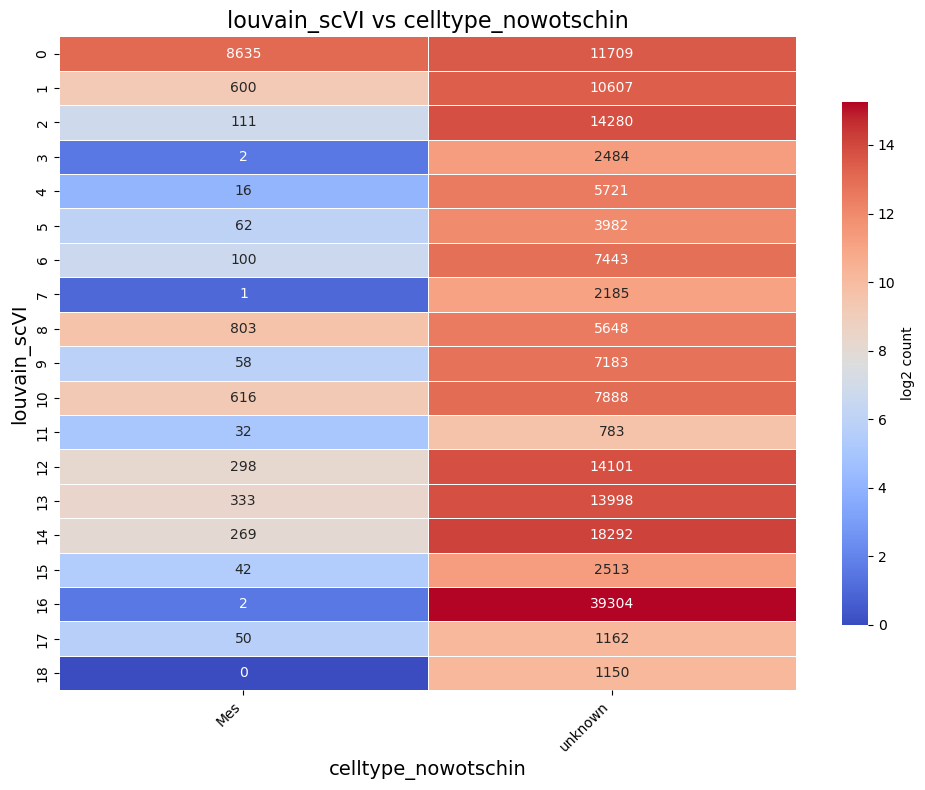

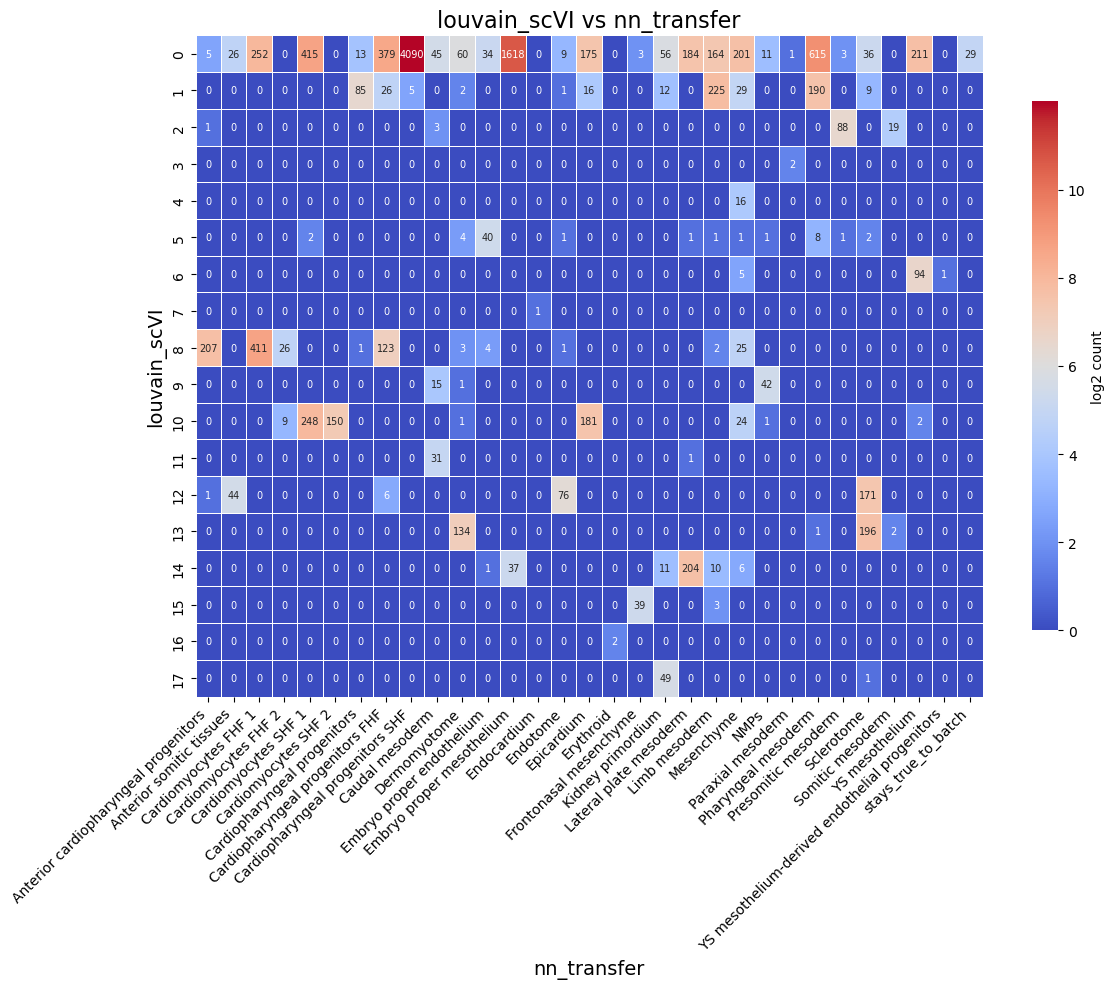

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

celltype = 'celltype_nowotschin'

# Step 1: Create contingency tables for both comparisons
contingency_table_1 = pd.crosstab(adata.obs['louvain_scVI'], adata.obs[f'{celltype}'])
contingency_table_2 = pd.crosstab(adata.obs['louvain_scVI'], adata.obs['nn_transfer'])

# Step 2: Apply log2 transformation to each contingency table for the color scale
log2_contingency_table_1 = np.log2(contingency_table_1 + 1)  # Add 1 to avoid log(0)
log2_contingency_table_2 = np.log2(contingency_table_2 + 1)

# Plot 1: Heatmap for 'louvain_scVI' vs f'{celltype}'
plt.figure(figsize=(10, 8))
sns.heatmap(log2_contingency_table_1,
            annot=contingency_table_1,   # Use raw counts for annotations
            fmt="d",                     # Format annotations as integers
            cmap="coolwarm",             # Color map for better contrast
            linewidths=.5,               # Add gridlines for clarity
            cbar_kws={'shrink': .8, 'label': 'log2 count'},  # Adjust color bar
            annot_kws={"size": 10})
plt.title(f'louvain_scVI vs {celltype}', fontsize=16)
plt.xlabel(f'{celltype}', fontsize=14)
plt.ylabel('louvain_scVI', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout
plt.show()

# Plot 2: Heatmap for 'louvain_scVI' vs 'nn_transfer'
plt.figure(figsize=(12, 10))
sns.heatmap(log2_contingency_table_2,
            annot=contingency_table_2,   # Use raw counts for annotations
            fmt="d",                     # Format annotations as integers
            cmap="coolwarm",             # Use same color map for consistency
            linewidths=.5,               # Add gridlines for clarity
            cbar_kws={'shrink': .8, 'label': 'log2 count'},  # Adjust color bar
            annot_kws={"size": 7})
plt.title('louvain_scVI vs nn_transfer', fontsize=16)
plt.xlabel('nn_transfer', fontsize=14)
plt.ylabel('louvain_scVI', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for clarity
plt.tight_layout()  # Adjust layout
plt.show()


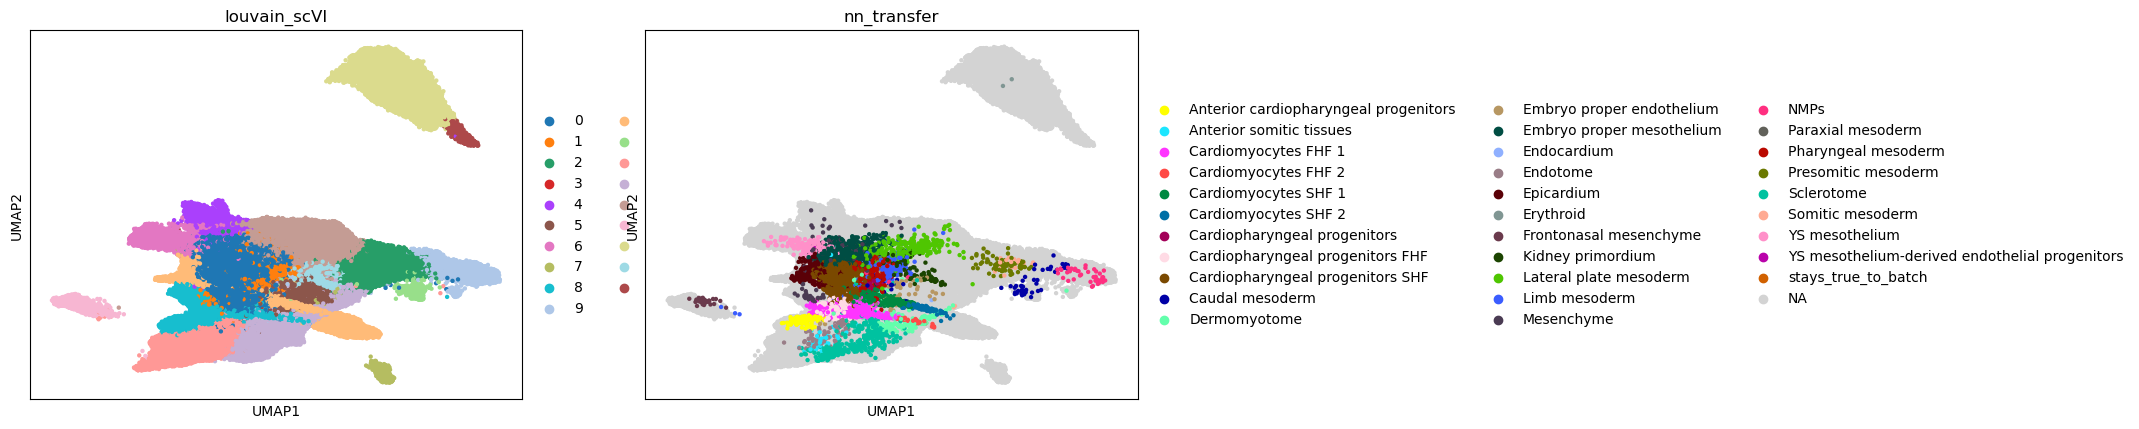

In [72]:
sc.pl.umap(adata, color = ['louvain_scVI', 'nn_transfer'], size = 40)

In [74]:
## SETTING THE CELLS THAT STAY TRUE_TO_BATCH 

adata.obs.loc[(adata.obs['louvain_scVI'] == '0') & (adata.obs['nn_transfer'] == 'stays_true_to_batch'), 'nn_transfer'] = 'Cardiopharyngeal progenitors SHF'

In [78]:
adata.obs['nn_transfer'].value_counts()

Cardiopharyngeal progenitors SHF                  4124
Embryo proper mesothelium                         1655
Pharyngeal mesoderm                                814
Cardiomyocytes SHF 1                               665
Cardiomyocytes FHF 1                               663
Cardiopharyngeal progenitors FHF                   534
Sclerotome                                         415
Limb mesoderm                                      405
Lateral plate mesoderm                             390
Epicardium                                         372
YS mesothelium                                     307
Mesenchyme                                         307
Anterior cardiopharyngeal progenitors              214
Dermomyotome                                       205
Cardiomyocytes SHF 2                               150
Kidney primordium                                  128
Cardiopharyngeal progenitors                        99
Caudal mesoderm                                     94
Presomitic

## SAVE DATA AND MODELS 

In [75]:
data_path = '/data/hadjantalab/lucas/atlas/data'

In [76]:
file_path = os.path.join(data_path, 'adata_meso_cohort80-95.h5ad')
adata.write_h5ad(file_path)

In [77]:
%%time
file_path = os.path.join(data_path, "scvi/meso_cohort80-95")
model.save(file_path, overwrite = True)

CPU times: user 42 ms, sys: 5.13 ms, total: 47.1 ms
Wall time: 423 ms


In [79]:
## Save the nearest neighbor reannotation
reanno_meso_cohort80_95_nn_transfer = adata.obs['nn_transfer']
file_path = os.path.join(data_path, "reanno_meso_cohort80-95_nn-transfer.csv")
reanno_meso_cohort80_95_nn_transfer.to_csv(file_path, index=True)

## LOAD ADATA & MODEL

In [66]:
data_path = '/data/hadjantalab/lucas/atlas/data'

In [67]:
#file_path = os.path.join(data_path, 'adata_meso_cohort80-95.h5ad')
#adata = ad.read_h5ad(file_path)

In [68]:
# Load the model using the custom pickle module
#file_path = os.path.join(data_path, "scvi/meso_cohort80-95")
#model = scvi.model.SCVI.load(file_path, adata)

In [69]:
# load scvi model
#file_path = os.path.join(data_path, "scanvi/meso_cohort80-95")
#model_scanvi = scvi.model.SCANVI.load(file_path, adata)